### Fashion-Clip image 

### Create Embedding with fashion-clip

tensor([[9.9993e-01, 6.6761e-05]], grad_fn=<SoftmaxBackward0>)


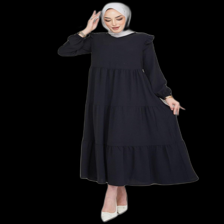

In [4]:
from PIL import Image
from rembg import remove
import requests
from transformers import CLIPProcessor, CLIPModel

input_path = 'tests/data/test_image.jpg'
output_path = 'tests/data/test_image_rem.jpg'

input = Image.open(input_path)
output = remove(input)
output = output.convert("RGB")


output.save(output_path)

image = Image.open("tests/data/test_image_rem.jpg")


model = CLIPModel.from_pretrained("patrickjohncyh/fashion-clip")
processor = CLIPProcessor.from_pretrained("patrickjohncyh/fashion-clip")


inputs = processor(text=["a photo of a black dress", "a photo of a black shoe"],
                   images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  
print(probs)


image.resize((224, 224))

### Create embedding with combined_model.onnx

In [4]:
import onnxruntime as ort
from transformers import AutoTokenizer

# Load the ONNX model
sess = ort.InferenceSession("models/image/model:.onnx")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/clip-ViT-B-32-multilingual-v1')

# Prepare the text
text = "This is an example sentence."
inputs = tokenizer(text, padding='longest', truncation=True, max_length=128, return_tensors='np')

# Run inference
input_names = sess.get_inputs()
input_dict = {input_name.name: inputs[input_name.name] for input_name in input_names}

import time

start_time = time.time()
inputs = tokenizer(text, padding='longest', truncation=True, max_length=128, return_tensors='np')

# Run inference
input_names = sess.get_inputs()
input_dict = {input_name.name: inputs[input_name.name] for input_name in input_names}

output_dict = sess.run(None, input_dict)
end_time = time.time()

print(f"Time taken: {(end_time - start_time) * 1000} milliseconds")


# The output is a list of numpy arrays, one for each output tensor
# print(output_dict)

import numpy as np

# Take the mean of the output along the sequence length dimension
# mean_output = np.mean(output_dict[0], axis=1)

print(output_dict[0])
import json

# Convert the tensor to a list
output_list = output_dict[0].tolist()

with open('embedding.json', 'w') as f:
    json.dump(output_list, f)

Time taken: 4.876136779785156 milliseconds
[-1.26431406e-01  1.03924178e-01 -9.06252712e-02 -1.16209410e-01
 -1.91176921e-01 -1.43773332e-02 -1.63840994e-01 -1.41228139e+00
  3.42575192e-01 -7.24642305e-04  2.37428080e-02  1.82638362e-01
  1.42683402e-01 -2.04959169e-01  1.83473438e-01 -1.49883740e-02
 -9.43370238e-02  2.80145258e-02 -2.11930588e-01 -7.85048008e-02
  6.16276711e-02 -1.26432091e-01  1.72459960e-01 -3.41832429e-01
 -1.47544846e-01  1.70714810e-01 -1.50460646e-01 -2.35026971e-01
  2.82157630e-01 -6.23078272e-02  1.14018589e-01 -5.09377718e-02
  1.37666613e-01  8.92706960e-02  2.19570339e-01  2.68463999e-01
  3.69729966e-01 -5.66888601e-02  1.94477022e-01 -3.64378363e-01
  1.96955115e-01 -3.16487610e-01  7.82806799e-02  4.95261475e-02
  2.04724133e-01  2.51980215e-01  2.99986303e-01  1.94996685e-01
  4.60869633e-02 -4.34494168e-02 -2.18412057e-01 -4.18978930e-01
 -4.98592481e-02 -1.20867960e-01  8.79129488e-03  8.15327391e-02
  1.77408978e-01 -4.02529180e-01 -1.06028266e-0

###m compare both model output

### Compare the operation counts

In [70]:
import onnx.shape_inference

# Infer the shapes of the models
transformers_onnx_model = onnx.shape_inference.infer_shapes(transformers_onnx_model)
combined_model = onnx.shape_inference.infer_shapes(combined_model)

# Get the output shapes
transformers_output_shape = [dim.dim_value for dim in transformers_onnx_model.graph.output[0].type.tensor_type.shape.dim]
combined_output_shape = [dim.dim_value for dim in combined_model.graph.output[0].type.tensor_type.shape.dim]

# Compare the output shapes
if transformers_output_shape == combined_output_shape:
    print("The output shapes of the two models are identical.")
else:
    print("The output shapes of the two models are different.")
    print("Transformers ONNX model output shape:", transformers_output_shape)
    print("Combined ONNX model output shape:", combined_output_shape)

The output shapes of the two models are different.
Transformers ONNX model output shape: [0, 0, 768]
Combined ONNX model output shape: [0]


In [92]:
# Function to get all operations
def get_all_operations(model):
    return [node for node in model.graph.node]

# Get all operations in each model
transformers_operations = get_all_operations(transformers_onnx_model)
combined_operations = get_all_operations(combined_model)

# Function to extract the last part of a string after the last '/' or '.'
def extract_last_part(s):
    if '/' in s:
        return s.split('/')[-1]
    else:
        return s.split('.')[-1]


for i in range(min(len(transformers_operations), len(combined_operations))):
    transformers_operation = transformers_operations[i]
    combined_operation = combined_operations[i]

    # Check if the operations have any inputs
    if not transformers_operation.input or not combined_operation.input:
        print(f"Operation {i} does not have any inputs.")
        # print("Transformers ONNX model operation:", transformers_operation)
        # print("Combined ONNX model operation:", combined_operation)

        # Compare the rest of the operation
        transformers_output = extract_last_part(transformers_operation.output[0])
        transformers_name = extract_last_part(transformers_operation.name)
        combined_output = extract_last_part(combined_operation.output[0])
        combined_name = extract_last_part(combined_operation.name)

        if (transformers_output != combined_output or
            transformers_name != combined_name or
            transformers_operation.op_type != combined_operation.op_type or
            transformers_operation.attribute != combined_operation.attribute):
            print(f"Unequal operation {i}.")
        else:
            print(f"Identical operation {i}.")
        continue  # Skip to the next iteration

    # Extract the last part of the input, output, and name strings
    transformers_input = extract_last_part(transformers_operation.input[0])
    transformers_output = extract_last_part(transformers_operation.output[0])
    transformers_name = extract_last_part(transformers_operation.name)

    combined_input = extract_last_part(combined_operation.input[0])
    combined_output = extract_last_part(combined_operation.output[0])
    combined_name = extract_last_part(combined_operation.name)

    # Compare the operations
    if (transformers_input != combined_input or
        transformers_output != combined_output or
        transformers_name != combined_name or
        transformers_operation.op_type != combined_operation.op_type or
        transformers_operation.attribute != combined_operation.attribute):
        print(f"Unequal operation {i}.")
        print("Transformers ONNX model operation:", transformers_operation)
        print("Combined ONNX model operation:", combined_operation)
    else:
        print(f"Identical operation {i}.")

# ...

# Print the total number of operations in each model
print(f"Total operations in Transformers ONNX model: {len(transformers_operations)}")
print(f"Total operations in Combined ONNX model: {len(combined_operations)}")

# ...

# If the Combined ONNX model has more operations, print the last operation
if len(combined_operations) > len(transformers_operations):
    print("Excess operation in Combined ONNX model:", combined_operations[-1])

Identical operation 0.
Identical operation 1.
Operation 2 does not have any inputs.
Identical operation 2.
Identical operation 3.
Operation 4 does not have any inputs.
Unequal operation 4.
Operation 5 does not have any inputs.
Identical operation 5.
Operation 6 does not have any inputs.
Identical operation 6.
Operation 7 does not have any inputs.
Unequal operation 7.
Operation 8 does not have any inputs.
Unequal operation 8.
Operation 9 does not have any inputs.
Unequal operation 9.
Unequal operation 10.
Transformers ONNX model operation: input: "embeddings.position_embeddings.weight"
input: "/embeddings/Slice_output_0"
output: "/embeddings/position_embeddings/Gather_output_0"
name: "/embeddings/position_embeddings/Gather"
op_type: "Gather"

Combined ONNX model operation: input: "onnx::Slice_110"
input: "/transformer/transformer.0/auto_model/embeddings/Constant_2_output_0"
input: "/transformer/transformer.0/auto_model/embeddings/Unsqueeze_output_0"
input: "/transformer/transformer.0/au